<a href="https://colab.research.google.com/github/gu0y1/CS3244/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Available at [Canvas](https://https://www.nus.edu.sg/canvas/) "CS3244/Assignments/Assignment 1 (Individual)"

---

**Make sure you reserve sufficient time to upload your exported copy to Canvas.**


# Assignment

We have introduced $k$**-Nearest Neighbors** and **Decision Trees** in the lectures on Weeks 02 and 03. In this **individual** assignment, you will be graded on implementing the models yourself. You will run both models and compare their performance on the same dataset. Overall, you will learn to appreciate the similarities and differences in models to predict on the same problem.

## Assignment Instructions

Before the assignment, you should create a copy of this Colab file in your own Google Drive.

In this assignment, you will

1. Follow the instructions to familiarize yourself with the `wine` dataset;
2. Write your code in the designated spaces to finish the implementations of the $k$-Nearest Neighbor and Decision Tree algorithms;
2. Run the notebook to obtain your results;
3. Upload this Colab file into Canvas "CS3244/Assignments/Assignment 1 (Individual)"


## 1. Programming: $k$-NN and Decision Tree from `sklearn`

### .a Loading and Visualizing Input data


We'll use the [Wine](https://archive.ics.uci.edu/ml/datasets/Wine) dataset from the popular [UCI dataset repository](https://archive.ics.uci.edu/ml/index.php).  This describes the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 chemical constituents found in each of the three types of wines.

We'll load in the data for white wines, take a look around and split the data into parts for training the model and testing it.

In [45]:
# Import the standard tools for pythonic data analysis.
import csv
import math
import random
import numpy as np
import pandas as pd

# Let's read the data in as a "data frame" (df), equivalent to our D = (X,y) data matrix
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',sep=';') # Separate on semicolons

We want to apply matchine learning algorithms to predict the quality of the wine from its constituents. That is, we will utilize algorithms that can find the correlation between wine quality and its 13 constituent (as features) to make prediction. To better understand how algorithms can achieve this, we need to inspect the data distribution first.
<!-- (actually, we can predict any feature from any other feature, there's really no particular distinction between $\mathbf{x}$ and $y$).   -->
Let's take a look at the distribution for **quality**. This tells us the how the wine quality is distributed without knowing anything about other information. Go ahead and run the below cell.

Number of wines of a particular rating:
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64


array([[<Axes: title={'center': 'quality'}>]], dtype=object)

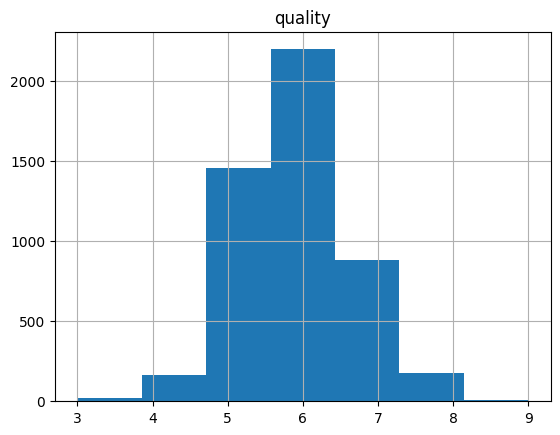

In [46]:
# Get numeric distributions of our quality output
print("Number of wines of a particular rating:")
counts = df['quality'].value_counts()
print(counts)

# Let's do a histogram plot. To do that we need to specify the
# y-axis that we want to plot – i.e. 'quality' – and number of bins
df.hist(column = 'quality', bins = len(counts))

This looks somewhat normally distributed.  Let's say we care about good wines.  Then we'll just concentrate on differentiating great wines from the rest. Our task is now a classification. As we can see from the histogram below, the two classes are heavily imbalanced -- we have far more "Not Good" wines than the "Good" wines.

<Axes: title={'center': 'Distribution of classes'}>

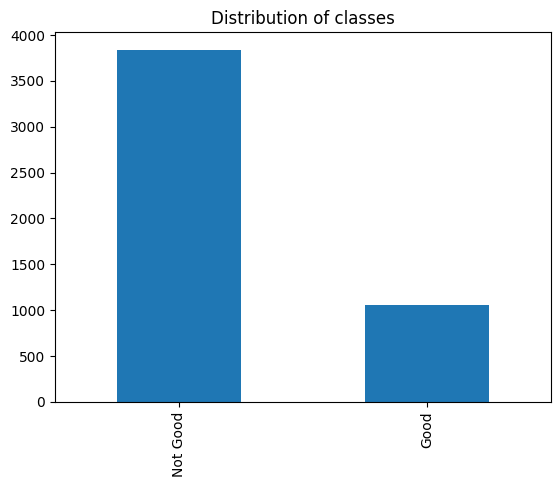

In [47]:
# Create a new column called good wine, where the value of the quality is 7 or better.
df['good wine'] = np.where(df['quality']>=7, "Good", "Not Good")

# Then remove the quality column (why)
df.drop('quality', axis=1, inplace=True)

df['good wine'].value_counts().plot(kind = 'bar', title = 'Distribution of classes')

### .b Split dataset into train and test

Let's split the data into training and testing data sets before we do anything else.   It's important to look only at the training data to develop our intuitions (**why?**)

In [48]:
# Learn how to split test and training data from a whole
from sklearn.model_selection import train_test_split

# Partion the features from the class to predict
df_X = df[df.columns[df.columns != 'good wine']].copy() # get columns that are not 'good wine'
df_y = df['good wine'].copy() # get the column named 'good wine'; this is our label

# (random_state): we use a fixed random seed so we get the same results every time.
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=1)

print ("Number of training instances: ", len(X_train), "\nNumber of test instances: ", len(X_test))

Number of training instances:  3428 
Number of test instances:  1470


Let's look at the first few rows of the training portion of the dataset.  Understanding the data is **always** important in trying to build any model for prediction.
You can check against the description of the dataset which is here: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names

In [49]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
4554,6.0,0.23,0.34,1.3,0.025,23.0,111.0,0.98961,3.36,0.37,12.7
3401,8.8,0.19,0.30,5.0,0.028,34.0,120.0,0.99242,2.94,0.47,11.2
3330,6.7,0.23,0.33,8.1,0.048,45.0,176.0,0.99472,3.11,0.52,10.1
4462,7.1,0.42,0.20,2.8,0.038,28.0,109.0,0.98968,3.23,0.47,13.4
3171,7.3,0.20,0.39,2.3,0.048,24.0,87.0,0.99044,2.94,0.35,12.0


We can also take a look at some general statistics.

In [50]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000
mean,6.852728,0.278197,0.334387,6.392255,0.045682,35.408693,138.459160,0.994048,3.185656,0.491362,10.488486
std,0.834514,0.101933,0.122178,5.077153,0.021071,17.272270,42.755363,0.003001,0.151288,0.113687,1.218602
min,3.800000,0.080000,0.000000,0.600000,0.012000,3.000000,18.000000,0.987130,2.740000,0.230000,8.000000
25%,6.300000,0.210000,0.260000,1.700000,0.036000,23.000000,108.000000,0.991750,3.080000,0.410000,9.400000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993735,3.180000,0.480000,10.300000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,168.000000,0.996120,3.280000,0.550000,11.341667
max,11.800000,1.100000,1.230000,65.800000,0.346000,289.000000,440.000000,1.038980,3.810000,1.080000,14.200000


### .c Train and Test the models

Actually all of the above was just preparation. Now we have some intution, let's try fitting the dataset on both $k$ - NN and Decision Tree models using sklearn's API library.

In [51]:
# Get the machine learning algorithm k-NN
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors = 1, metric='euclidean')
knn_model = knn.fit(X_train, y_train)
print('kNN accuracy for training set: %f' % knn_model.score(X_train, y_train))
print('kNN accuracy for test set: %f' % knn_model.score(X_test, y_test))

kNN accuracy for training set: 1.000000
kNN accuracy for test set: 0.794558


In [52]:
# Get the machine learning algorithm Naïve Bayes
from sklearn.tree import DecisionTreeClassifier

# Fix the random seed for decision tree classifier
np.random.seed(seed=0)
dt = DecisionTreeClassifier(max_depth=None)
dt_model = dt.fit(X_train,y_train)
print('Decision Tree accuracy for training set: %f' % dt_model.score(X_train, y_train))
print('Decision Tree accuracy for test set: %f' % dt_model.score(X_test, y_test))

Decision Tree accuracy for training set: 1.000000
Decision Tree accuracy for test set: 0.819048


After running these experiments you should have been able to get about 79% accuracy (on test set) for the nearest neighbor code and about 82% accuracy (on test set) using the Decision Tree algorithm.  

That was easy! But it is important to know how to master these models yourself, so you're going to implement from scratch.  You'll practice this in the next sections.

To ease the implementation in the next section, we'll first transform the data into `numpy` arrays and transform the labels into lists.

In [53]:
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
y_train, y_test = y_train.to_list(), y_test.to_list()

## 2. Programming : Implement $k$-Nearest Neighbor (kNN)

We are going to implement a kNN to predict whether the wine is "Good" or "Not good" (so it is a binary or 2-class classification).

Next we are going to build a list of helper functions to help build the kNN model. Your task is to implement these functions.

### .a Calculate Manhattan_distance

**Manhattan Distance**: Manhattan Distance measures the sum of the absolute differences of two vectors' Cartesian coordinates.

$$
L_1(a, b) = |a_1-b_1| + |a_2-b_2| + \cdots + |a_n-b_n|
$$

**Your Turn (Question 1):** Complete the code below to calculate the Manhattan Distance between two data points.

In [54]:
def manhattan_distance(a, b):
    """
    Args:
      a (D) : a data point in numpy array of dimension D
      b (D) : a data point in numpy array of dimension D
    Returns:
      dis(float): the Manhattan distance between the two data points
    """
    dis = 0
    ###########################
    #
    # Your Turn (Q1): Write your code here
    # Hint: calculate vector c which is the element-wise absolute difference between vector a and b; find out the sum of all elements in c
    # Hint: use the numpy library to speed up matrix and vector operations like difference, summation and square root. https://numpy.org/doc/stable/user/quickstart.html
    #
    ###########################
    c = np.abs(a - b)
    dis = np.sum(c)
    return dis

### .b Calculate Euclidean_distance

**Euclidean Distance**: Euclidean Distance measures the length of the line segment bewteen two points in the Euclidean space.

$$
L_2(a, b) = \sqrt{(a_1-b_1)^2 + (a_2-b_2)^2 + \cdots + (a_n-b_n)^2}
$$

Compared to the definition of Manhattan distance, it is natural to generalize the Euclidean Distance and Manhattan Distance into Minkowski Distance.

**Minkowski Distance**: Minkowski Distance measures the p-order distance between two points. It is obvious that $p=1$ refers to Manhattan Distance while $p=2$ refers to Euclidean Distance.

$$
L_p(a, b) = (|a_1-b_1|^p + |a_2-b_2|^p + \cdots + |a_n-b_n|^p)^{\frac{1}{p}}
$$

**Your Turn (Question 2):** Complete the code below to calculate the Minkowski Distance between two data points.

In [55]:
def minkowski_distance(a, b, p):
    """
    Args:
      a (D) : a data point in numpy array of dimension D
      b (D) : a data point in numpy array of dimension D
      p     : distance order
    Returns:
      dis(float): the Minkowski distance between the two data points
    """
    dis = 0
    ###########################
    #
    # Your Turn (Q2): Write your code here
    # Hint: calculate vector c which is the element-wise difference between vector a and b
    # Hint: calculate p-norm of vector c; numpy.linalg.norm() is suggested to prevent data overflow; please refer to https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
    #
    ###########################
    c = a - b
    dis = np.linalg.norm(c, ord=p)
    return dis

**Testing**: test to see if the Minkowski distance is consistent with your manual calculation.

In [56]:
x1 = np.asarray([1, 2, 3])
x2 = np.asarray([0, 0, 0])
print('Minkowski Distance (p=1) between (1, 2, 3) and (0, 0, 0):', minkowski_distance(x1, x2, p=1))
print('Minkowski Distance (p=2) between (1, 2, 3) and (0, 0, 0):', minkowski_distance(x1, x2, p=2))

print('------------------------------------------------------------------')
x1 = np.asarray([100, 20, 30])
x2 = np.asarray([0, 0, 0])
print('Minkowski Distance (p=1) between (100, 20, 30) and (0, 0, 0):', minkowski_distance(x1, x2, p=1))
print('Minkowski Distance (p=2) between (100, 20, 30) and (0, 0, 0):', minkowski_distance(x1, x2, p=2))

Minkowski Distance (p=1) between (1, 2, 3) and (0, 0, 0): 6.0
Minkowski Distance (p=2) between (1, 2, 3) and (0, 0, 0): 3.7416573867739413
------------------------------------------------------------------
Minkowski Distance (p=1) between (100, 20, 30) and (0, 0, 0): 150.0
Minkowski Distance (p=2) between (100, 20, 30) and (0, 0, 0): 106.30145812734649


From the tests above, we can see that the Minkowski Distance (p=2) is closer to the dimension in which the two vectors have the largest difference, *e.g.*, $(100-0)$, $(3-0)$ than Minkowski Distance (p=1). **Why?**

**Testing**: test to see if the Minkowski distance (p=1) is consistent with Manhattan distance.

In [57]:
x1 = np.asarray([1.5, 2.5, 3.5])
x2 = np.asarray([0., 0., 0.])
print('Manhattan Distance between (1.5, 2.5, 3.5) and (0., 0., 0.):', manhattan_distance(x1, x2))
print('Minkowski Distance (p=1) between (1.5, 2.5, 3.5) and (0., 0., 0.):', minkowski_distance(x1, x2, p=1))

x1 = np.asarray([10., 20., 30.])
x2 = np.asarray([13., 4., 7.])
print('Manhattan Distance between (10., 20., 30.) and (13., 4., 7.):', manhattan_distance(x1, x2))
print('Minkowski Distance (p=1) between (10., 20., 30.) and (13., 4., 7.):', minkowski_distance(x1, x2, p=1))

Manhattan Distance between (1.5, 2.5, 3.5) and (0., 0., 0.): 7.5
Minkowski Distance (p=1) between (1.5, 2.5, 3.5) and (0., 0., 0.): 7.5
Manhattan Distance between (10., 20., 30.) and (13., 4., 7.): 42.0
Minkowski Distance (p=1) between (10., 20., 30.) and (13., 4., 7.): 42.0


Since we can use minkowski_distance to calculate both Manhattan Distance and Euclidean Distance, we will keep using minkowski_distance function instead of manhattan_distance in the following programming.

**Optional**: test to see what happened when p > 2.

In [58]:
# Testing: This should return 84.44345780422779
print(minkowski_distance(X_test[0], X_train[0], p=2))

# Testing: This should return 99.69812000000002
print(minkowski_distance(X_test[0], X_train[0], p=1))

84.44345780422779
99.69812000000002


### .c Find k Nearest Neighbors

**$k$-NN function**: The $k$-NN function will find the k nearest data points given an array of distances. We want to return the corresponding labels of the k Nearest Neighbors.

**Your Turn (Question 3):** Complete the code below to find out the kNN's labels with the given array of distances.

In [59]:
def find_kNN_labels(distances, labels, k):
    """
    Args:
      distances (m,) : a numpy array of dimension m that contains the distances between the test data point and all training data points
      labels (m,) : a list of length m that contains the labels of all training data points
      k: the number of nearest neighbors
    Returns:
      knn_labels (k,): the labels of the k nearest neighbors
    """

    knn_labels = []
    ###########################
    #
    # Your Turn (Q3): Write your code here
    # Hint: use numpy.argsort function to sort distances array and obtain the sorted indice; select the k indice with the least distances; return the corresponding labels of the selected k indice
    # Hint: use "slicing", e.g., list_of_names[:k], to select the first k elements in python list and numpy array. https://stackoverflow.com/questions/509211/understanding-slice-notation
    #
    ###########################

    # get the distances
    sorted_indices = np.argsort(distances)
    # Select the indices of the k smallest distances
    k_smallest_indices = sorted_indices[:k]
    knn_labels = [labels[i] for i in k_smallest_indices]

    return knn_labels

# Testing: This should return [2, 1, 0, 1, 2]
sample_distances = [1.97, 1.94, 0.16, 0.91, 2.05, 1.5, 1.86, 2.01, 1.9, 1.67, 1.9, 1.14, 2.1, 1.94, 2.68, 0.08, 3.98, 3.05, 1.59, 2.4]
sample_labels = [0, 0, 1, 0, 1, 2, 1, 2, 1, 0, 1, 1, 0, 2, 1, 2, 0, 2, 2, 1]
print(find_kNN_labels(sample_distances, sample_labels, 5))

[2, 1, 0, 1, 2]


### .d Find the Majority Class

**Majority Class Function**: When finding the $k$-Nearest Neighbors, we return the value that represents the majority of the $k$ instances of the class as the answer.

**Your Turn (Question 4):** Complete the code below to find the majority class from the dataset.

In [60]:
def get_majority_class(labels):
    """
    Args:
      labels(m): The corresponding labels of current sub-dataset
          m: num_rows
    Returns:
      major: Type:String. The major class of this sub-dataset(e.g "Good Wine" or "Not Good")
    """
    major = ""

    # freq will store the number of occurences of the target labels
    freq = {}
    for entry in labels:
        if (entry in freq):
            freq[entry] += 1.0
        else:
            freq[entry] = 1.0

    major = ""
    ###########################
    #
    # Your Turn (Q4): Write your code here
    # Hint: Loop through each entry in labels, then find which entry occurs most frequently.
    #
    #
    ###########################

    # freq will store the number of occurrences of the target labels
    freq = {}
    for entry in labels:
        if entry in freq:
            freq[entry] += 1
        else:
            freq[entry] = 1

    # Find the label with the maximum frequency
    major = max(freq, key=freq.get)
    return major


# Testing: This should return 'Good'
sample_y = y_train[50:56]
print(get_majority_class(sample_y))

Good


### .e Run $k$-NN

The following code `run_knn` is provided to you to run your kNN helper functions.

You do not have to understand its code for the purpose of this exercise. Just run it and check the accuracy.

Note that because the prediction of a single data points requires traversing the whole training set. The code is a bit slow. It can take $2\sim 4$ minutes.

In [61]:
def run_knn(distance_metric_function, **kwags):
    k = 1
    correct = 0
    for test_entry, label in zip(X_test, y_test):

        ## find out the distance between the test data point and all training data points
        distances = []
        for train_entry in X_train:
            distances.append(distance_metric_function(test_entry, train_entry, **kwargs))

        knn_labels = find_kNN_labels(distances, y_train, k)
        prediction = get_majority_class(knn_labels)

        if prediction == label:
            correct += 1

    accuracy = correct / len(y_test)
    print('Final accuracy')
    print(accuracy)

The following code runs $k$-NN with the Euclidean distance.

In [62]:
## The accuracy should be 0.7945578231292517.
kwargs = {}
kwargs['p'] = 2
run_knn(minkowski_distance, **kwargs) # note that minkowski_distance is a function, not a value

Final accuracy
0.7945578231292517


The following code runs $k$-NN with the Manhattan distance.

In [63]:
## The accuracy should be 0.8020408163265306
kwargs = {}
kwargs['p'] = 1
run_knn(minkowski_distance, **kwargs)

Final accuracy
0.8020408163265306


**Optional**: The following code runs $k$-NN with the Minkowski distance (p=10).

In [64]:
## The accuracy should be 0.7925170068027211
kwargs = {}
kwargs['p'] = 10
run_knn(minkowski_distance, **kwargs)

Final accuracy
0.7925170068027211


## 3. Programming : Implement Decision Tree

We are going to implement a decision tree to predict whether the wine is "Good" or "Not good" (again, it is a 2-class classification).

### .a Discretize the Dataset

We are going to make use of 11 _attributes_ (also known as _features_ or _input dimensions_, but for this decision trees to be consistent with the algorithm, we'll use "attributes").

In this assignment, we will implement a basic version of Decision tree that takes in categorical attributes. Thus, we are going to discretize the continuous features, where values **larger** than the mean is assigned **1** and values **smaller** than the mean is assigned **0**.

In [65]:
def discretize_data(train_data, test_data):
    """
    Args:
        train_data (np array): the training set
        test_data (np array): the test set

    Returns:
    np_train_data (np array): contains the discretized training set
    np_test_data (np array): contains the discretized test set
    """
    train_data_discrete = np.zeros_like(train_data) # initialize
    test_data_discrete = np.zeros_like(test_data)

    D = train_data_discrete.shape[1]

    for i in range(D):
        mean_value = np.mean(train_data[:, i]) # get mean values at which to label as 1 (larger) or 0 (smaller)
        train_data_discrete[:, i] = (train_data[:, i] > mean_value).astype(float)
        test_data_discrete[:, i] = (test_data[:, i] > mean_value).astype(float)

    return train_data_discrete, test_data_discrete

X_train_discrete, X_test_discrete = discretize_data(X_train, X_test)

In [66]:
sample_X = X_train_discrete[10:20]
sample_y = y_train[10:20]
sample_X, sample_y

(array([[1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.],
        [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.]]),
 ['Not Good',
  'Good',
  'Not Good',
  'Not Good',
  'Not Good',
  'Not Good',
  'Good',
  'Good',
  'Good',
  'Not Good'])

### .b Choose the best Feature based on Majority

**Majority Class Function**: When you reach a terminal node (leaf) in a decision tree, we return the label that represents the majority of the sub-dataset's instances of the class as the answer.

We can reuse the `get_majority_class` function from the implementation of $k$-Nearest Neighbors

### .c Calculate Entropy

**Entropy Function**: Calculate the entropy of this current sub-dataset:

Recall: $H(X) = - \sum_{i=0}^C p_i\log_2(p_i)$

**Your Turn (Question 5):** Complete the code below to calculate entropy of the dataset.

In [67]:
def entropy(labels):
    """
    Args:
      labels(m): The corresponding labels of current sub-dataset of the sub-tree
          m: num_rows
    Returns:
      dataEntropy: The entropy of this current sub-dataset
    """
    dataEntropy = 0.0
    # freq will store the number of occurrences of the target labels
    freq = {}
    for entry in labels:
        if (entry in freq):
            freq[entry] += 1.0
        else:
            freq[entry] = 1.0

    ###########################
    #
    # Your Turn (Q5): Write your code here
    #
    ###########################

    total = sum(freq.values())
    for entry in freq:
        probability = freq[entry] / total
        dataEntropy -= probability * math.log2(probability)

    return dataEntropy

# Testing: This should return 0.9709505944546686 (in log 2)
print(entropy(sample_y))

0.9709505944546686


### .d Calculate Information Gain

**Information Gain**: The information gained by splitting the current (sub)-dataset using the attribute.

Recall:  Information Gain is a metric that measures the expected reduction in the impurity of the collection $S$, caused by splitting the data according to any given attribute. A chosen attribute $x_i$ divides the example set S into subsets
$S_1 , S_2 , ... , S_{C_i}$ according to the $C_i$ distinct values for $x_i$ .
The entropy then reduces to the entropy of the subsets $S_1 , S_2 , ... , S_{C_i}$:

<div align="center">
$\text{remainder}(S, x_i) = \sum_{j=1}^{C_i} \frac{|S_j|}{|S|} H(S_j)$
</div>

The Information Gain (IG; “reduction in entropy”) from knowing the value of $x_i$ is:
<div align="center">
$IG(S, x_i) = H(S) - \text{remainder}(S, x_i) $  
</div>

Subsequently, we choose the attribute with the largest IG.

**Your Turn (Question 6):** Complete the code below to calculate information gain of a given attribute.

In [68]:
def info_gain(data, labels, attribute, attributes):
    """
    Args:
      data(m, D): The current sub-dataset of the sub-tree
          m: num_rows
          D: num_features
      labels(m): The corresponding labels of current sub-dataset of the sub-tree
          m: num_rows
      attribute: The attribute used to split data
      attributes: The list of current remaining attributes
    Returns:
      info_gain : information gain of the given dataset
    """

    freq = {}
    subsetEntropy = 0.0

    # Get the column index of this attribute
    i = attributes.index(attribute)

    for entry in data:
        if (entry[i] in freq):
            freq[entry[i]] += 1.0
        else:
            freq[entry[i]]  = 1.0

    ###########################
    #
    # Your Turn (Q6): Write your code here
    # Hint: Split the data based on the value at index i. Find the subsetEntropy of
    # each sub-dataset, then use the formula of Information Gain to calculate subsetEntropy.
    #
    ###########################
    total_entropy = entropy(labels)
    freq = {}
    subsetEntropy = 0.0

    # Get the column index of this attribute
    i = attributes.index(attribute)

    # Splitting the data based on the attribute and counting occurrences
    for index, entry in enumerate(data):
        key = entry[i]
        if key not in freq:
            freq[key] = []
        freq[key].append(labels[index])

    # Calculating the entropy for each subset and their weighted sum
    for key in freq:
        subset_labels = freq[key]
        subset_prob = len(subset_labels) / float(len(data))
        subset_entropy = entropy(subset_labels)
        subsetEntropy += subset_prob * subset_entropy

    return (entropy(labels) - subsetEntropy)

# Testing: This should return 0.01997309402197489
attributes = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
print(info_gain(sample_X, sample_y, 'residual sugar', attributes))

0.01997309402197489


### .e Find the Best Attribute

Now we will write a function to choose the **best** (most discriminating) attribute for a given data, here best indicates having **largest** information gain (IG) among all attributes.

**Your Turn (Question 7):** Complete the code below to get the best attribute based on information gain.

In [69]:
def get_best_gain_attribute(data, labels, attributes):
    """
    Args:
      data(m, D): The current sub-dataset of the sub-tree
          m: num_rows
          D: num_features + 1 (last column is the label)
      attributes: The list of current remaining attributes
    Returns:
      best: The best attribute to split based on info gain.
    """
    best = attributes[0]

    max_gain = 0
    for attr in attributes:
      ###########################
      #
      # Your Turn (Q7): Write your code here
      # Hint: For each attribute in attributes, use info_gain function above
      # to know which attribute is the best option
      for attr in attributes:
        # Calculate the information gain for each attribute
        current_gain = info_gain(data, labels, attr, attributes)
        # Update the best attribute if current_gain is higher than max_gain
        if current_gain > max_gain:
            max_gain = current_gain
            best = attr
      pass
      ###########################
    return best

# Testing: This should return 'citric acid'
attributes = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
print(get_best_gain_attribute(sample_X, sample_y, attributes))

citric acid


### .f Helper Functions

We will define two helper functions here. First, `get_unique_values` returns the unique values of a given attribute. The second function, `get_sub_data` returns the subset of rows (instances) containing a specific value of a chosen attribute.

In [70]:
# These two functions are helper functions
# This function will get unique values for that particular attribute from the given data
def get_unique_values(data, attributes, attribute):
    """
    Args:
      data (m,D) : Current subset of data
      attributes : The list of current remaining attributes
      attribute : Our point of interest

    Returns:
      values : List of unique values for our point of interest
    """
    index = attributes.index(attribute)
    values = []
    #
    for entry in data:
        if entry[index] not in values:
            values.append(entry[index])

    return values

# This function will get all the rows of the data where the chosen "best" attribute has a value "val"
def get_sub_data(data, labels, attributes, best, val):
    """
    Args:
      data (m,D) : Current subset of data
      labels (m) : Corresponding labels of current subset of data
      attributes : The list of current remaining attributes
      best : The attribute of which data we will extract
      val : We are interested only on this value of the `best` attribute
    Returns:
      new_data : Data subset containing only those rows where `best` attribute = val
      new_labels : Label subset containing only those values where `best` attribute = val
    """
    new_data = [[]]
    new_labels = []
    attribute_index = attributes.index(best)

    for index, entry in enumerate(data):
        if (entry[attribute_index] == val):
            newEntry = []
            for i in range(0,len(entry)):
                if(i != attribute_index):
                    newEntry.append(entry[i])
            new_data.append(newEntry)
            new_labels.append(labels[index])
    new_data.remove([])
    return new_data, new_labels

### .g Build the Decision Tree

In the below code, your task is to build a tree recursively. Starting at the root, pick the best attribute to split on, and call the `build_tree` function on each of the sub-trees.  Check the inlined code comments for clarification.

**Your Turn (Question 8):** Complete the code below to build the tree.

In [71]:
def build_tree(data, labels, attributes, default):
    """
      Args:
        data(m, D): The current sub-dataset of the sub-tree
            m: num_rows
            D: num_features + 1 (last column is the label)
        attributes: The list of current remaining attributes
      Returns:
        tree: The constructed tree as object. For example if the root is gender,
              then a tree of depth 2 is like
              {'gender': {'male': sub_tree1, 'female': sub_tree2}}
    """
    data = data[:]
    tree = {}
    ##################################################################
    ## Your Turn (Q8): Finish the implementation of the below code ##
    ##################################################################
    if len(data) == 0 or len(attributes) == 0:
        return default

    # Base case: If all labels are the same, return that label
    if all(label == labels[0] for label in labels):
        return labels[0]

    # Choose the best attribute to split the data
    best_attribute = get_best_gain_attribute(data, labels, attributes)
    tree = {best_attribute: {}}

    # Get unique values for the best attribute
    attribute_index = attributes.index(best_attribute)
    unique_values = set(row[attribute_index] for row in data)

    for value in unique_values:
        # Create subsets of data and labels based on the attribute value
        subset_data = [row for row in data if row[attribute_index] == value]
        subset_labels = [labels[i] for i, row in enumerate(data) if row[attribute_index] == value]

        # Determine the default label for the next level
        default_label = max(set(labels), key=labels.count)

        # Recursively build the subtree
        if subset_data:
            subtree = build_tree(subset_data, subset_labels, [attr for attr in attributes if attr != best_attribute], default_label)
        else:
            subtree = default_label

        # Add the subtree to the tree
        tree[best_attribute][value] = subtree

    return tree

The below code block containing `run_decision_tree` does exactly as its name, and you don't have to understand its code for the purpose of this exercise. Just run it and check the accuracy.

In [72]:
# Class Node which will be used while classifying a test instance using the tree built ("fit") earlier
class Node():
    value = ""
    children = []

    def __init__(self, val, dictionary):
        self.value = val
        if (isinstance(dictionary, dict)):
            self.children = list(dictionary.keys())

def run_decision_tree():
    attributes = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
    tree = build_tree(X_train_discrete, y_train, attributes, get_majority_class(y_train))
    results = []

    for entry, label in zip(X_test_discrete, y_test):
        tempDict = tree.copy()
        result = ""
        while(isinstance(tempDict, dict)):
            root = Node(list(tempDict.keys())[0], tempDict[list(tempDict.keys())[0]])
            tempDict = tempDict[list(tempDict.keys())[0]]
            index = attributes.index(root.value)
            value = entry[index]
            if(value in list(tempDict.keys())):
                child = Node(value, tempDict[value])
                result = tempDict[value]
                tempDict = tempDict[value]
            else:
                result = "Null"
                break
        if result != "Null":
            results.append(result == label)

    accuracy = float(results.count(True))/float(len(results))
#     print(results)
    print("FINAL ACCURACY: ")
    print(accuracy)

In [73]:
run_decision_tree()

FINAL ACCURACY: 
0.8247787610619469


## 4. Comparison between $k$-NN and Decision Tree

The above is akin to a skeleton of a machine learning project.  Critical for understanding is knowing why the performance of a learner is as it is. As a scientist, you'll want to know why you think a learner performs well or poorly and **then** use experiments to verify your hunches.  To build up this skill we need to practice it, as you'll need to apply this in your own group projects later.

**Your Turn (Question 9):** Compare the performances of our implementation of $k$-NN and decision tree. Tell us what you have observed and why one of the models performs better than the other.

**Your answer here (Question 9)**: _Write down your answer in the current cell.  A brief 1–3 sentence answer is sufficient._

**Your Turn (Question 10):** Compare the running times of $k$-NN and decision tree. Briefly tell us why $k$-NN is much slower than the other.

**Your answer here (Question 10)**: _Write down your answer in the current cell.  A brief 1–3 sentence answer is sufficient._

**Your Turn (Question 11):** Compare the performances of your implementation of decision tree and sklearn's implementation. Which one has the better performance? Why do you think that is?

**Your answer here (Question 11)**: _Write down your answer in the current cell.  A brief 1–3 sentence answer is sufficient._

**Your Turn (Question 12):** Identify an instance where $k$-NN predicts a different label than Decision Tree. Briefly tell us why you think they predicted differently, and what can you do to make them agree more?

**Your answer here (Question 12)**: _Write down your answer in the current cell.  A brief 1–3 sentence answer is sufficient._

Congratulations 🎉 🎉 ! You have come to the end of the assignment.
**Remember** to submit your "Your Turn" code, results, and answers to Canvas to be graded for your work.